In [1]:
# 1. Imports
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from torch.utils.data import Dataset

# 2. Load Dataset
df = pd.read_csv("dataset/data_to_be_cleansed.csv")
df = df[['text', 'target']]

# 3. Convert target column to multi-label format
df = df.groupby('text')['target'].apply(list).reset_index()

# Emotion classes: 0=Stress, 1=Depression, 2=Bipolar, 3=Personality disorder, 4=Anxiety
mlb = MultiLabelBinarizer(classes=[0, 1, 2, 3, 4])
labels = mlb.fit_transform(df['target'])

# 4. Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], labels, test_size=0.2, random_state=42
)

# 5. Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)

# 6. Create Dataset class
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# 7. Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5,
    problem_type="multi_label_classification"
)

# 8. Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10
)

# 9. Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# 10. Train
trainer.train()

# 11. Save Model
model.save_pretrained("./emotion_model")
tokenizer.save_pretrained("./emotion_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.584900
20,0.502500
30,0.502900
40,0.486400
50,0.484200
60,0.460600
70,0.468600
80,0.442600
90,0.399800
100,0.350900


('./emotion_model/tokenizer_config.json',
 './emotion_model/special_tokens_map.json',
 './emotion_model/vocab.txt',
 './emotion_model/added_tokens.json',
 './emotion_model/tokenizer.json')

## Training and Validation Trends

In [4]:
# Evaluate all saved checkpoints and build a summary table.
import os, re, json, math
import numpy as np
import pandas as pd
import torch

from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

from sklearn.metrics import precision_recall_fscore_support

# ---------- metrics with threshold sweep ----------
def _compute_metrics(eval_pred):
    # Supports both (preds, labels) tuple and EvalPrediction object
    try:
        logits, labels = eval_pred
    except Exception:
        logits, labels = eval_pred.predictions, eval_pred.label_ids

    # robust to lists / tuples
    logits = np.asarray(logits)
    labels = np.asarray(labels)

    # Sigmoid for multilabel probabilities
    probs = 1.0 / (1.0 + np.exp(-logits))

    thresholds = np.linspace(0.0, 1.0, 101)
    best = {"f1": -1.0, "p": 0.0, "r": 0.0, "t": 0.5}
    for t in thresholds:
        preds = (probs >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            labels, preds, average="macro", zero_division=0
        )
        if f1 > best["f1"]:
            best.update({"f1": f1, "p": p, "r": r, "t": float(t)})

    return {
        "f1_macro": round(best["f1"], 4),
        "precision_macro": round(best["p"], 4),
        "recall_macro": round(best["r"], 4),
        "best_threshold": round(best["t"], 2),
    }

def _steps_per_epoch_guess(train_dataset=None, per_device_bs=8):
    try:
        n = len(train_dataset)
    except Exception:
        return None
    if not isinstance(n, int) or n <= 0:
        return None
    
    world_size = 1
    grad_accum = 1
    return max(1, math.ceil(n / (per_device_bs * world_size * grad_accum)))

def table_from_checkpoints(
    checkpoints_dir="./results",
    eval_dataset=None,
    tokenizer=None,
    per_device_eval_batch_size=8,
    train_dataset=None,           # only to estimate epoch numbers
    per_device_train_batch_size=8
):
    # ----- discover checkpoints -----
    if not os.path.isdir(checkpoints_dir):
        raise FileNotFoundError(f"{checkpoints_dir} does not exist.")
    ckpts = []
    for name in os.listdir(checkpoints_dir):
        m = re.match(r"checkpoint-(\d+)$", name)
        if m and os.path.isdir(os.path.join(checkpoints_dir, name)):
            ckpts.append((int(m.group(1)), os.path.join(checkpoints_dir, name)))
    ckpts.sort(key=lambda x: x[0])
    if not ckpts:
        raise RuntimeError(
            f"No 'checkpoint-XXXX' folders found under {checkpoints_dir}. "
            "Run training with `save_steps` set or point to the correct output_dir."
        )

    # ----- map step -> last seen training loss (from trainer_state.json) -----
    step2loss = {}
    state_path = os.path.join(checkpoints_dir, "trainer_state.json")
    if os.path.exists(state_path):
        try:
            with open(state_path, "r") as f:
                state = json.load(f)
            last_loss = None
            for ev in state.get("log_history", []):
                if "loss" in ev:
                    last_loss = ev["loss"]
                if "step" in ev and last_loss is not None:
                    step2loss[int(ev["step"])] = last_loss
        except Exception:
            pass  # ignore if unreadable

    # ----- collator -----
    collator = DataCollatorWithPadding(tokenizer) if tokenizer is not None else None

    # ----- device -----
    device = (
        torch.device("cuda")
        if torch.cuda.is_available()
        else torch.device("mps")
        if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
        else torch.device("cpu")
    )

    # ----- eval-only Trainer arguments -----
    eval_args = TrainingArguments(
        output_dir=os.path.join(checkpoints_dir, "_tmp_eval"),
        per_device_eval_batch_size=per_device_eval_batch_size,
        dataloader_drop_last=False,
        report_to=[],   # no logging integrations needed for eval-only
    )

    rows = []
    spe = _steps_per_epoch_guess(train_dataset, per_device_train_batch_size)

    # ----- evaluate each checkpoint -----
    for step, path in ckpts:
        model = AutoModelForSequenceClassification.from_pretrained(path)
        
        if getattr(model.config, "problem_type", None) != "multi_label_classification":
            model.config.problem_type = "multi_label_classification"
        model.to(device)

        eval_tr = Trainer(
            model=model,
            args=eval_args,
            eval_dataset=eval_dataset,
            compute_metrics=_compute_metrics,
            data_collator=collator,
        )
        metrics = eval_tr.evaluate()

        epoch = (step // spe) + 1 if spe is not None else "-"
        train_loss = step2loss.get(step)

        rows.append({
            "Epoch": epoch,
            "Step": step,
            "Training Loss": round(float(train_loss), 4) if train_loss is not None else None,
            "Validation Loss": round(float(metrics.get("eval_loss")), 4)
                if metrics.get("eval_loss") is not None else None,
            "f1_macro": metrics.get("eval_f1_macro"),
            "precision_macro": metrics.get("eval_precision_macro"),
            "recall_macro": metrics.get("eval_recall_macro"),
            "best_threshold": metrics.get("eval_best_threshold"),
        })

    df = pd.DataFrame(rows).sort_values("Step").reset_index(drop=True)

    # tidy numbers
    for c in ["f1_macro", "precision_macro", "recall_macro"]:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce").round(4)
    if "best_threshold" in df:
        df["best_threshold"] = pd.to_numeric(df["best_threshold"], errors="coerce").round(2)

    return df

# ---------- Run ----------
multi_epoch_table = table_from_checkpoints(
    checkpoints_dir="./results",
    eval_dataset=val_dataset,        
    tokenizer=tokenizer,             
    per_device_eval_batch_size=8,    
    train_dataset=train_dataset,     
    per_device_train_batch_size=8
)

multi_epoch_table

,Epoch,Step,Training Loss,Validation Loss,f1_macro,precision_macro,recall_macro,best_threshold
0,2,500,None,0.2918,0.7224,0.7499,0.6992,0.46
1,3,1000,None,0.3024,0.7358,0.7329,0.7431,0.33
2,4,1326,None,0.3148,0.7332,0.7253,0.7427,0.30


In [2]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./emotion_model", tokenizer="./emotion_model", return_all_scores=True)

text = "I'm feeling really overwhelmed and exhausted."
results = classifier(text)[0]

# Show as percentages
for result in results:
    label = mlb.classes_[int(result['label'].replace("LABEL_", ""))]
    print(f"{label}: {result['score'] * 100:.2f}%")

Device set to use mps:0
/Users/sourabhpratapwar/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


0: 17.61%
1: 5.41%
2: 1.15%
3: 1.40%
4: 35.66%


## Performance Metrics

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, hamming_loss, classification_report,
    confusion_matrix
)

# 1) Predict on validation set
pred_out = trainer.predict(val_dataset)
logits = pred_out.predictions
labels = pred_out.label_ids

# 2) Sigmoid -> probabilities
probs = 1.0 / (1.0 + np.exp(-logits))

# 3) Tune global threshold for multilabel macro-F1
thresholds = np.linspace(0.0, 1.0, 101)
best_t, best_f1 = 0.5, -1.0
for t in thresholds:
    preds_t = (probs >= t).astype(int)
    f1_t = f1_score(labels, preds_t, average="macro", zero_division=0)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, float(t)

# 4) Final multilabel predictions
preds = (probs >= best_t).astype(int)

# ---- Text metrics ----
h_loss = hamming_loss(labels, preds)
labelwise_accuracy = 1.0 - h_loss
subset_acc = accuracy_score(labels, preds)
micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

print(f" Hamming Loss: {h_loss}")
print(f" Accuracy (label-wise): {labelwise_accuracy}")
print(f" Micro F1 Score: {micro_f1}")
print(f" Macro F1 Score: {macro_f1}")
print(f" Subset Accuracy (exact match): {subset_acc}\n")

target_names = ["Stress", "Depression", "Bipolar Disorder", "Personality Disorder", "Anxiety"]
if labels.shape[1] != len(target_names):
    target_names = [f"Class {i}" for i in range(labels.shape[1])]

print("Classification Report:\n")
print(classification_report(labels, preds, target_names=target_names, digits=2, zero_division=0))

 Hamming Loss: 0.11040723981900452
 Accuracy (label-wise): 0.8895927601809954
 Micro F1 Score: 0.7291897891231964
 Macro F1 Score: 0.733152009356654
 Subset Accuracy (exact match): 0.6990950226244343

Classification Report:

                      precision    recall  f1-score   support

              Stress       0.78      0.76      0.77       152
          Depression       0.66      0.73      0.69       207
    Bipolar Disorder       0.74      0.80      0.77       152
Personality Disorder       0.75      0.70      0.73       186
             Anxiety       0.71      0.72      0.72       191

           micro avg       0.72      0.74      0.73       888
           macro avg       0.73      0.74      0.73       888
        weighted avg       0.72      0.74      0.73       888
         samples avg       0.72      0.74      0.73       888



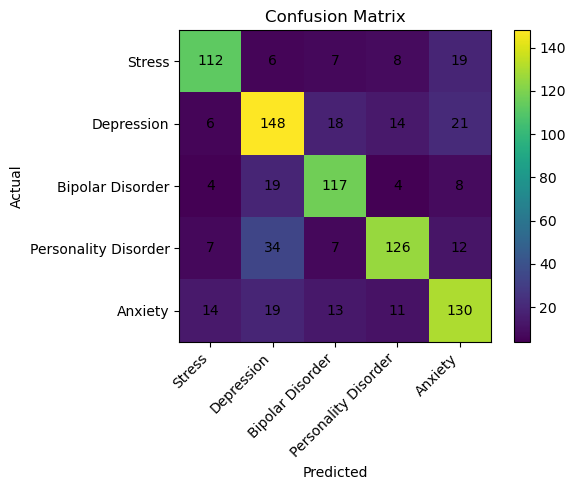

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ---- Multiclass-style Confusion Matrix via argmax ----
n_classes = labels.shape[1]
if len(target_names) != n_classes:
    target_names = [f"Class {i}" for i in range(n_classes)]

y_true_single = labels.argmax(axis=1)
y_pred_single = probs.argmax(axis=1)

cm = confusion_matrix(y_true_single, y_pred_single, labels=list(range(n_classes)))

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(cm)  

ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_xticklabels(target_names, rotation=45, ha="right")
ax.set_yticklabels(target_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()